In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

from astropy.modeling.models import Lorentz1D, Const1D
import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack
from scipy.interpolate import interp1d
from stingray.utils import rebin_data_log
from stingray.gti import bin_intervals_from_gtis
from hendrics.base import r_in, r_det
from stingray.modeling.posterior import GaussianLogLikelihood
from stingray.modeling.parameterestimation import ParameterEstimation
import os
import glob
from pandas import read_csv

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d

## What about different fluxes?

In [2]:
from hendrics.io import load_events, load_lcurve, load_pds, save_lcurve, save_pds
from stingray.gti import cross_two_gtis
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum, AveragedCrossspectrum

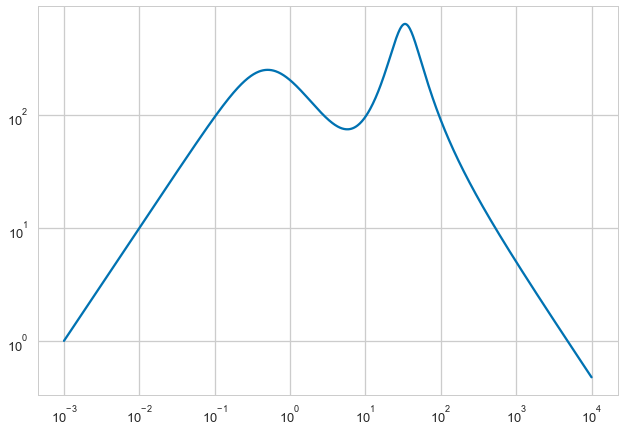

In [3]:
model = Lorentz1D(x_0=0, fwhm=1, amplitude=1000) + \
        Lorentz1D(x_0=30, fwhm=30, amplitude=20)

freqs = np.logspace(-3, 4, 1000)
plt.figure()
plt.loglog(freqs, model(freqs) * freqs)

In [20]:
from astropy.modeling.models import Lorentz1D
from stingray.events import EventList

def create_model_lightcurve(model, tstart=0, tstop=8192, dt=1/1024, 
                            mean_ctrate=200, rms=0.25): 

    time = np.arange(tstart, tstop, dt)

    # The current normalization is not precise for very high count rates!
    sim = Simulator(N=len(time), dt=dt, rms=1, 
                    mean=10000, red_noise=3)
    sim_lc_clean = sim.simulate(model)

    # Correct normalization
    sim_lc_clean.counts -= np.mean(sim_lc_clean.counts)
    factor = rms / np.std(sim_lc_clean.counts)
    sim_lc_clean.counts *= factor
    sim_lc_clean.counts += 1
    sim_lc_clean.counts *= mean_ctrate
    
    sim_lc_clean.counts *= dt

    return sim_lc_clean


In [5]:
def create_event_lists_from_lightcurve(lc_in, channel_ratio=1):
    # work on a copy, not on the original light curve
    lc = copy.deepcopy(lc_in)
    events = EventList()
    events.simulate_times(lc)
    event_times1 = events.time

    lc.counts *= channel_ratio
    events.simulate_times(lc)
    event_times2 = events.time
    return event_times1, event_times2

def create_lightcurve_with_deadtime(event_times, dt, tstart=0, tstop=8192, 
                                    deadtime=2.5e-3):
    gti = [[tstart, tstop]]
    lc_clean = Lightcurve.make_lightcurve(event_times, 
                                          gti=gti, 
                                          tstart=tstart, tseg=tstop - tstart,
                                          dt=dt)
    events_dt = filter_for_deadtime(event_times, deadtime)
    lc = Lightcurve.make_lightcurve(events_dt, 
                                    gti=gti, 
                                    tstart=tstart, tseg=tstop - tstart,
                                    dt=dt)
    return lc_clean, lc

   
def create_lightcurves_with_deadtime(lc_in, channel_ratio=1, 
                                     lc_dt=1/2048, deadtime=2.5e-3):
    
    event_times1, event_times2 = \
        create_event_lists_from_lightcurve(lc_in, channel_ratio=channel_ratio)

    lc1_clean, lc1 = \
        create_lightcurve_with_deadtime(event_times1, lc_dt, 
                                        tstart=lc_in.tstart, 
                                        tstop=lc_in.tseg - lc_in.tstart,
                                        deadtime=deadtime)
    lc2_clean, lc2 = \
        create_lightcurve_with_deadtime(event_times2, lc_dt, 
                                        tstart=lc_in.tstart, 
                                        tstop=lc_in.tseg - lc_in.tstart,
                                        deadtime=deadtime)

    return lc1_clean, lc1, lc2_clean, lc2

def calculate_and_save_freq_spectrum(lc1, lc2=None, segment_size=512, 
                                     file_name=None, norm='frac'):
    if lc2 is None:
        pds = AveragedPowerspectrum(lc1, segment_size=segment_size, 
                                    norm=norm)
        if file_name is None:
            file_name = 'pds.nc'
    else:
        pds = AveragedCrossspectrum(lc1, lc2, 
                                    segment_size=segment_size, 
                                    norm=norm)
        if file_name is None:
            file_name = 'cpds.nc'

#     print('Saving ' + file_name)
    save_pds(pds, file_name, save_all=False)

    return file_name

def modify_saved_power(in_file_name, new_unnorm_power, lc1=None, lc2=None,
                       out_file_name=None, norm='frac',
                       deadtime=2.5e-3):
    from hendrics.base import r_in
    if out_file_name is None:
        out_file_name = in_file_name.replace('.nc', '_out.nc')
    newpow = load_pds(in_file_name)

    newpow.norm = norm
    newpow.unnorm_power = new_unnorm_power
    newpow.power = new_unnorm_power
    if lc1 is not None:
        if lc2 is None:
            lc2 = lc1
        meanctrate = np.sqrt(lc1.meancounts * lc2.meancounts) / lc1.dt
        ratio = r_in(deadtime, meanctrate)/meanctrate
        meancounts = np.sqrt(lc1.meancounts * lc2.meancounts)
        meancounts_deadtimecorr = meancounts * ratio
        
        if norm == 'frac':
            c = newpow.unnorm_power / newpow.n**2 
            newpow.power = c * 2 * newpow.segment_size / meancounts **2
        elif norm == 'leahy':
            newpow.power = newpow.unnorm_power * 2 / (meancounts * newpow.n)

#     print('Saving ' + out_file_name)
    save_pds(newpow, out_file_name)


In [6]:
def calculate_fad_and_save_all_spectra(lc1, lc2, file_label='all_',
                                       segment_size=512, 
                                       smoothing_alg='gauss', 
                                       smoothing_length=None,
                                       norm='frac'):
    from fad_correction import FAD_power_spectra

    results = \
        FAD_power_spectra(lc1, lc2, segment_size=segment_size, smoothing_alg=smoothing_alg, 
                          smoothing_length=smoothing_length)

    freqs = results.freq
    pds1_norm = results.pds1
    pds2_norm = results.pds2
    crosssp_norm = results.cs
    ptot_norm = results.ptot
    is_compliant = results.is_compliant
    fad_delta = results.fad_delta

#     print('Fourier Amplitudes loaded')
    calculate_and_save_freq_spectrum(lc1, segment_size=segment_size, 
                                     file_name=file_label + 'pds1_dt.nc',
                                     norm=norm)
    calculate_and_save_freq_spectrum(lc2, segment_size=segment_size, 
                                     file_name=file_label + 'pds2_dt.nc',
                                     norm=norm)
    modify_saved_power(file_label + 'pds1_dt.nc', ptot_norm, lc1=lc1 + lc2, 
                       out_file_name=file_label + 'pdstot_norm.nc',
                                     norm=norm, deadtime=2.5e-3/2)
    modify_saved_power(file_label + 'pds1_dt.nc', pds1_norm, lc1=lc1, 
                       out_file_name=file_label + 'pds1_norm.nc',
                                     norm=norm)
    calculate_and_save_freq_spectrum(lc1, lc2, segment_size=segment_size, 
                                     file_name=file_label + 'cs_dt.nc',
                                     norm=norm)
    modify_saved_power(file_label + 'pds1_dt.nc', crosssp_norm, lc1=lc1, lc2=lc2, 
                       out_file_name=file_label + 'cs_norm.nc',
                                     norm=norm)
    return fad_delta

In [7]:
def load_rebinned(file, rebin_factor, kind='lin'):
    periodogram = load_pds(file)
    if kind == 'lin' and isinstance(rebin_factor, int):
        return periodogram.rebin(f=rebin_factor)
    elif kind == 'lin':
        return periodogram.rebin(df=rebin_factor)
    else:
        return periodogram.rebin_log(rebin_factor)
    

In [8]:
def simulate_spectrum(model, channel_ratio=1, rebin_factor=0.02, segment_size=512,
                      label=None, tstart = 0, tstop = 8192, smoothing_alg='gauss',
                      smoothing_length=None, rms=0.25, mean_ctrate=200, norm='frac'):
    

    sim_lc = create_model_lightcurve(model, tstart, tstop, rms=rms,
                                     mean_ctrate=mean_ctrate)
    lc1_clean, lc1, lc2_clean, lc2 = \
        create_lightcurves_with_deadtime(sim_lc, 
                                         channel_ratio=channel_ratio, 
                                         lc_dt=1/2048, deadtime=2.5e-3)
    if label is None:
        label = '{:.2f}'.format(channel_ratio * 100)
    calculate_and_save_freq_spectrum(lc1_clean + lc2_clean, segment_size=segment_size, 
                                     file_name=label + 'pdstot_clean.nc',
                                     norm=norm)

    calculate_and_save_freq_spectrum(lc1_clean, lc2_clean, segment_size=segment_size, 
                                     file_name=label + 'cs_clean.nc',
                                     norm=norm)
    
    fad_delta = \
        calculate_fad_and_save_all_spectra(lc1, lc2, file_label=label, 
                                           segment_size=segment_size,
                                           smoothing_alg=smoothing_alg, 
                                           smoothing_length=smoothing_length,
                                           norm=norm)
    return label, fad_delta


In [9]:
# label, fad_delta = \
#     simulate_spectrum(model, tstop=1024, segment_size=512, smoothing_alg='gauss')

In [28]:
def subtract_mean_or_not(power, white_fmin=0, white_fmax=2048, doit=True):
    if doit:
        good = (power.freq >= white_fmin)&(power.freq < white_fmax)
        offset = np.mean(power.power[good])
    else:
        offset = 0
    return power.power - offset

def plot_spectrum(file_label, rebin_factor=0.02, step=0.,
                  white_fmin=0, white_fmax=2048, xlim=None, ylim=None,
                  show=False, subtract_mean=True):
    cs_dt_reb = load_rebinned(file_label + 'cs_dt.nc', rebin_factor)
    cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
    pds_norm_reb = load_rebinned(file_label + 'pds1_norm.nc', rebin_factor)
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    pds1_dt_reb = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)
    cs_clean_reb = load_rebinned(file_label + 'cs_clean.nc', rebin_factor)
    pds_clean_reb = load_rebinned(file_label + 'pdstot_clean.nc', rebin_factor)

    lw=2
    fig = plt.figure()
    plt.plot(pds1_dt_reb.freq, 
             subtract_mean_or_not(pds1_dt_reb, white_fmin, white_fmax, subtract_mean), 
             label='PDS 1', drawstyle='steps-mid', zorder=10, lw=lw)
    plt.plot(pds_norm_reb.freq, 
             subtract_mean_or_not(pds_norm_reb, white_fmin, white_fmax, subtract_mean) + step, 
             label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, color='r')
    plt.plot(pdstot_norm_reb.freq, 
             subtract_mean_or_not(pdstot_norm_reb, white_fmin, white_fmax, subtract_mean) + 2*step, 
             label='PDS 1+2, FAD-normalized', drawstyle='steps-mid', lw=lw, color='b')
    plt.plot(cs_dt_reb.freq, cs_dt_reb.power + 3 * step, 
             label='Cospectrum', drawstyle='steps-mid', lw=lw, color='grey')
    plt.plot(cs_norm_reb.freq, cs_norm_reb.power + 4 * step, 
             label='Cospectrum, FAD-normalized', drawstyle='steps-mid', lw=lw, color='k')
    plt.plot(cs_clean_reb.freq, cs_clean_reb.power + 5 * step, 
             label='Cospectrum, no dead time', drawstyle='steps-mid', lw=lw, color='purple')
    plt.plot(pds_clean_reb.freq, 
             subtract_mean_or_not(pds_clean_reb, white_fmin, white_fmax, subtract_mean) + 6*step, 
             label='PDS, no dead time', drawstyle='steps-mid', lw=lw, color='brown')
    plt.legend(loc=1)

    if step > 0:
        for i in range(4):
            plt.axhline(step * i, ls = '--', color='k', zorder=20)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Frequency (Hz)')
    if pds_clean_reb.norm == 'frac':
        plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')
    else:
        plt.ylabel(r'Leahy power')

    if not show:
        plt.savefig(file_label + 'rebin.jpg')
        plt.close(fig)
    else:
        return fig

def plot_spectrum_log(file_label, rebin_factor=0.02, step=0.,
                      white_fmin=0, white_fmax=2048, xlim=None, ylim=None,
                      show=False):
    cs_dt_reb_log = load_rebinned(file_label + 'cs_dt.nc', rebin_factor, kind='log')
    cs_norm_reb_log = load_rebinned(file_label + 'cs_norm.nc', rebin_factor, kind='log')
    pds_norm_reb_log = load_rebinned(file_label + 'pds1_norm.nc', rebin_factor, kind='log')
    pdstot_norm_reb_log = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor, kind='log')
    pds1_dt_reb_log = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor, kind='log')
    cs_clean_reb_log = load_rebinned(file_label + 'cs_clean.nc', rebin_factor, kind='log')
    lw=2
    fig, ax1 = plt.subplots()

    ax1.plot(cs_dt_reb_log.freq, cs_dt_reb_log.freq*cs_dt_reb_log.power, 
             label='Cospectrum', 
             lw=lw, drawstyle='steps-mid', color='grey', zorder=3)

    ax1.plot(cs_clean_reb_log.freq, cs_clean_reb_log.freq*cs_clean_reb_log.power, 
             label='Cospectrum, no dead time', 
             lw=lw, drawstyle='steps-mid', color='purple', zorder=3)

    ax1.plot(cs_norm_reb_log.freq, cs_norm_reb_log.freq*cs_norm_reb_log.power, 
             label='Cospectrum, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='k')

    good = (pds1_dt_reb_log.freq >= white_fmin)&(pds1_dt_reb_log.freq < white_fmax)

    lev = np.mean(pds_norm_reb_log.power.real[good])
    ax1.plot(pds_norm_reb_log.freq,
             pds_norm_reb_log.freq*(pds_norm_reb_log.power - lev), 
             alpha=0.6, label='PDS 1, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='r')

    lev = np.mean(pdstot_norm_reb_log.power.real[good])
    ax1.plot(pdstot_norm_reb_log.freq, 
             pdstot_norm_reb_log.freq*(pdstot_norm_reb_log.power - lev), 
             alpha=0.6, label='PDS 1, FAD-normalized', 
             lw=lw, drawstyle='steps-mid', color='b')

    ax1.legend()
    ax1.set_yscale('log', nonposy='clip')

    ax1.set_xscale('log', nonposx='clip')

    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)

    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel(r'${(\rm rms/mean)}^2$')
    
    if not show:
        plt.savefig(file_label + 'rebin_log.jpg')
        plt.close(fig)
    else:
        return fig

def plot_ratio(file_label, rebin_factor=0.02, step=0.,
                  white_fmin=512, white_fmax=2048, xlim=None, ylim=None,
                  show=False, subtract_mean=True, ratio_plot=False):
    cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
    pds_norm_reb = load_rebinned(file_label + 'pds1_norm.nc', rebin_factor)
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    cs_clean_reb = load_rebinned(file_label + 'cs_clean.nc', rebin_factor)
    pds_clean_reb = load_rebinned(file_label + 'pdstot_clean.nc', rebin_factor)

    lw=2
    factor = 1 / pds_clean_reb.power
    good = (cs_clean_reb.freq >= white_fmin)&(cs_clean_reb.freq < white_fmax)
    offset_cs = np.median(pds_clean_reb.power[good])

    fig = plt.figure()

    plt.plot(cs_clean_reb.freq, factor*(cs_clean_reb.power + offset_cs) + 5 * step, 
             label='Cospectrum, no dead time', drawstyle='steps-mid', lw=lw, color='purple')
    plt.plot(pds_clean_reb.freq, factor*pds_clean_reb.power + 6 * step, 
             label='PDS, no dead time', drawstyle='steps-mid', lw=lw, color='brown')
    plt.plot(pds_norm_reb.freq, 
             factor*subtract_mean_or_not(pds_norm_reb.power, 
                                         white_fmin, white_fmax, subtract_mean) + step, 
             label='PDS 1, FAD-normalized', drawstyle='steps-mid', lw=lw, color='r')
    plt.plot(pdstot_norm_reb.freq, 
             factor*subtract_mean_or_not(pdstot_norm_reb.power, 
                                         white_fmin, white_fmax, subtract_mean) + 2*step, 
             label='PDS 1+2, FAD-normalized', drawstyle='steps-mid', lw=lw, color='b')
    offset_cs = np.mean(pdstot_norm_reb.power[good])
    plt.plot(cs_norm_reb.freq, factor*(cs_norm_reb.power + offset_cs) + 4 * step, 
             label='Cospectrum, FAD-normalized', drawstyle='steps-mid', lw=lw, color='k')
    plt.legend(loc=1)

    if step > 0:
        for i in range(4):
            plt.axhline(step * i, ls = '--', color='k', zorder=20)

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

    if not show:
        plt.savefig(file_label + 'rebin.jpg')
        plt.close(fig)
    else:
        return fig

In [11]:
# plot_spectrum_log('100.00', rebin_factor=0.02, step=0., xlim=None, ylim=None)

In [12]:
def all_models_are_lists(model):
    if isinstance(model, Lorentz1D):
        const = Const1D(0)
        const.amplitude.fixed=True
        return(model + const)
    else:
        return model

def model_amp(model):
    amp1 = 0
    
    model = all_models_are_lists(model)

    for mo in model:
        if 'x_0' not in mo.param_names:
            continue
        amp1 += mo.amplitude
    return amp1
    
def model_ratio(model1, model2):
    amp1 = model_amp(model1)
    amp2 = model_amp(model2)
    return amp1 / amp2

def model_delta_rms(model1, model2):
    amp1 = model_amp(model1)
    amp2 = model_amp(model2)

    return (amp1**0.5 - amp2**0.5) / amp2**0.5

def fit_model_to_spectrum(filename, model, rebin_factor=0.02, label='PDS',
                          fmin=0, fmax=2048, fig=None, color='k', lock_freqs=True):
    model = all_models_are_lists(model)
    if lock_freqs:
        for mo in model:
            if 'x_0' not in mo.param_names:
                continue
            mo.x_0.fixed = True
            mo.fwhm.fixed = True

    spectrum = load_rebinned(filename, rebin_factor)
    maxmodel = np.max(model(spectrum.freq))
    maxspec = np.max(spectrum.power)
    ratio = maxspec/maxmodel
    for comp in model:
        comp.amplitude *= ratio

    good = (spectrum.freq < fmax)&(spectrum.freq >=fmin)

    lpost = GaussianLogLikelihood(spectrum.freq[good], spectrum.power[good], 
                                  np.sqrt(2/spectrum.m), copy.deepcopy(model))

    parest = ParameterEstimation()
    free_parameters = [getattr(model, par).value 
                       for par in model.param_names if not model.fixed[par]]

    res = parest.fit(lpost, free_parameters)
    if fig is not None:
        plot_fit_results(filename, res.model, label=label, fig=fig, color=color)
    return parest, res
    
def plot_fit_results(file, model, label='PDS', rebin_factor=0.02, ylim=None,
                     fig=None, color='k'):
    spectrum_log = load_rebinned(file, rebin_factor, kind='log')
    spectrum = load_rebinned(file, rebin_factor, kind='lin')
    freqs = spectrum.freq
    freqs_log = spectrum_log.freq
    
    offset = 0
    # If last model is a constant, not a Lorentzian
    if 'x_0' not in model[-1].param_names:
        offset = model[-1].amplitude

    powers = spectrum.power - offset
    powers_log = spectrum_log.power - offset
  
    lw=2
    closefig= False
    if fig is None:
        fig = plt.figure()
        closefig = True
    plt.plot(freqs, freqs*(model(freqs) - offset), color=color)
    for mo in model:
        if 'x_0' not in mo.param_names:
            continue
        plt.plot(freqs, freqs*mo(freqs), ls='--', color=color, lw=0.5)

    plt.plot(freqs_log, freqs_log * powers_log, 
             label=label, drawstyle='steps-mid', 
             lw=lw, zorder=3, color=color)

    plt.gca().set_yscale('log', nonposy='clip')
    plt.gca().set_xscale('log', nonposx='clip')

    plt.xlabel('Frequency (Hz)')
    plt.ylabel(r'${(\rm rms/mean)}^2$')
    if ylim is None:
        ylim = [1e-6, 0.5]
    plt.ylim(ylim)
    if closefig:
        plt.savefig(file.replace('.nc', '.jpg'))
        plt.close(fig)
    
def fit_model_to_all_data(file_label, model, rebin_factor=0.02, fmin=0, fmax=2048,
                          plot=True, print_results=True, fit_ref='cs'):
    from stingray.modeling import fit_powerspectrum
    
    model_cs = copy.deepcopy(model)
    model_pds = copy.deepcopy(model) + Const1D(0)    
    
    if plot:
        fig = plt.figure(file_label)
    else:
        fig = None

    pds_clean_parest, pds_clean_res = \
        fit_model_to_spectrum(file_label + 'pdstot_clean.nc', model_pds,
                              label='Clean PDStot', fig=fig, color='k',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)

    cs_clean_parest, cs_clean_res = \
        fit_model_to_spectrum(file_label + 'cs_clean.nc', model_cs,
                              label='Clean Cospectrum', fig=fig, color='#0000ff',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
        
    if fit_ref == 'pds':
        fit_ref_parest, fit_ref_res = pds_clean_parest, pds_clean_res
    elif fit_ref == 'cs':
        fit_ref_parest, fit_ref_res = cs_clean_parest, cs_clean_res

    cs_dt_parest, cs_dt_res = \
        fit_model_to_spectrum(file_label + 'cs_dt.nc', model_cs,
                              label='Cospectrum', fig=fig, 
                              color='#aaaaff',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    cs_norm_parest, cs_norm_res = \
        fit_model_to_spectrum(file_label + 'cs_norm.nc', model_cs, 
                              label='FAD-normalized Cospectrum', fig=fig, 
                              color='#5555ff',
                              rebin_factor=rebin_factor,fmin=fmin, fmax=fmax)
    pds_norm_parest, pds_norm_res = \
        fit_model_to_spectrum(file_label + 'pds1_norm.nc', model_pds, 
                              label='FAD-normalized PDS 1', fig=fig, 
                              color='#aaaaaa',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    pdstot_norm_parest, pdstot_norm_res = \
        fit_model_to_spectrum(file_label + 'pdstot_norm.nc', model_pds, 
                              label='FAD-normalized total PDS', fig=fig,
                              color='#555555',
                              rebin_factor=rebin_factor, fmin=fmin, fmax=fmax)
    
    spectrum = load_rebinned(file_label + 'pdstot_clean.nc', rebin_factor)
    meanrate_clean = spectrum.nphots/spectrum.segment_size / 2
    spectrum = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)
    meanrate = spectrum.nphots/spectrum.segment_size

    expected_gain = r_in(2.5e-3, meanrate)/meanrate
    gain_cs = model_ratio(cs_norm_res.model, cs_dt_res.model)**0.5
    
    delta_cs = model_delta_rms(cs_norm_res.model, fit_ref_res.model)
    delta_cs_clean = model_delta_rms(cs_clean_res.model, pds_clean_res.model)

    gain_pds_norm = model_ratio(pds_norm_res.model, cs_dt_res.model)**0.5

    delta_pds = model_delta_rms(pds_norm_res.model, fit_ref_res.model)

    gain_pds_clean = model_ratio(pds_clean_res.model, cs_dt_res.model)**0.5


    gain_pdstot_norm = model_ratio(pdstot_norm_res.model, cs_dt_res.model)**0.5
    delta_pdstot = model_delta_rms(pdstot_norm_res.model, fit_ref_res.model)

    if plot:
        plt.legend()
        plt.savefig(file_label + 'all_fit.jpg')
    
    if print_results:
        print('Estimated:', meanrate, r_in(2.5e-3, meanrate), 'Ratio:', expected_gain)
        print('Real: ', meanrate, meanrate_clean, 'Ratio:', meanrate_clean / meanrate)

        print("Measured frac. rms from clean spectrum: {:.2f}%".format(
              model_amp(fit_ref_res.model)**0.5 * 100))

        print("Measured frac. rms from fad-corrected cs: {:.2f}%".format(
              model_amp(cs_norm_res.model)**0.5 * 100))

        print("Measured frac. rms from fad-corrected total pds: {:.2f}%".format(
              model_amp(pdstot_norm_res.model)**0.5 * 100))

        print("Measured frac. rms from fad-corrected single pds: {:.2f}%".format(
              model_amp(pds_norm_res.model)**0.5 * 100))

        print("Measured frac. rms from deadtime-affected cs: {:.2f}%".format(
              model_amp(cs_dt_res.model)**0.5 * 100))


        print("rms gain expected from incident/detected "
              "ratio: {:.2f}".format(expected_gain))

        print("rms gain cs_norm/cs_dt: "
              "{:.2f} (correct to {:.1f}%)".format(gain_cs,
                                               ((gain_cs - expected_gain) / expected_gain) * 100))

        print("rms gain pds_norm/cs_dt: "
              "{:.2f} (correct to {:.1f}%)".format(gain_pds_norm,
                                               ((gain_pds_norm - expected_gain) / expected_gain) * 100))

        print("rms gain pds_clean/cs_dt: "
              "{:.2f} (correct to {:.1f}%)".format(gain_pds_clean,
                                                   ((gain_pds_clean - expected_gain) / expected_gain) * 100))

        print("rms gain pdstot_norm/cs_dt: "
              "{:.2f} (correct to {:.1f}%)".format(gain_pdstot_norm,
                                              ((gain_pdstot_norm - expected_gain) / expected_gain) * 100))

    deltas = {'delta clean': delta_cs_clean, 'CS': delta_cs, 'PDS': delta_pds, 
              'PDStot': delta_pdstot, 'Frac_rms': model_amp(fit_ref_res.model)**0.5}
    return deltas

In [13]:
# fit_model_to_all_data('100.00', model)

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


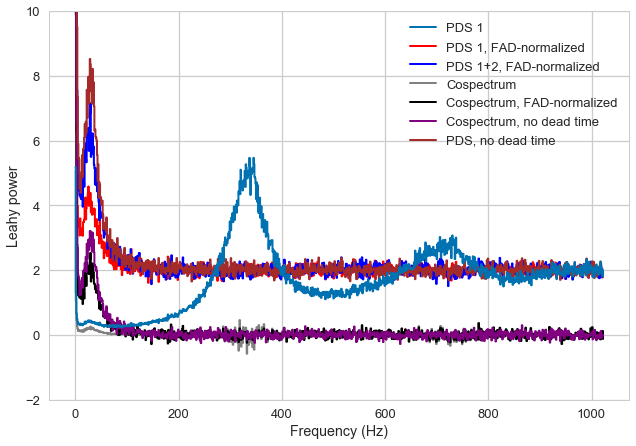

In [29]:
label, fad_delta = \
    simulate_spectrum(model, tstop=256, segment_size=128, 
                      smoothing_alg='gauss', rms=0.5, mean_ctrate=1000,
                      norm='leahy')
fig = plot_spectrum(label, rebin_factor=1., xlim=None, ylim=[-2, 10], show=True, subtract_mean=False)

In [25]:
model_highfreq = Lorentz1D(x_0=180, fwhm=30, amplitude=20) + Lorentz1D(x_0=30, fwhm=30, amplitude=20) + Lorentz1D(x_0=300, fwhm=30, amplitude=20)
label, fad_delta = \
    simulate_spectrum(model_highfreq, tstop=2048, segment_size=128, 
                      smoothing_alg='gauss', rms=0.5, mean_ctrate=1000,
                      norm='frac')

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


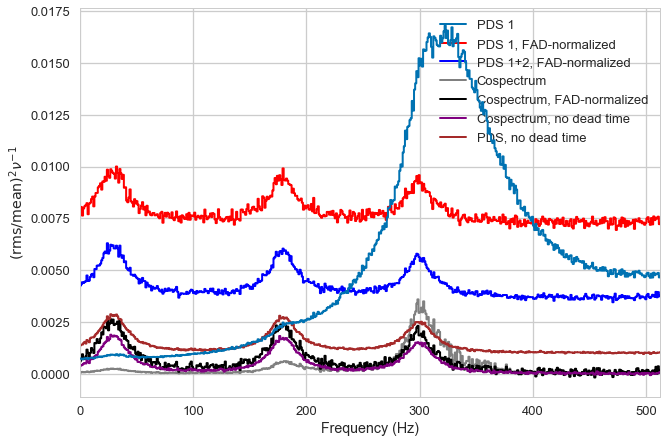

In [27]:
fig = plot_spectrum(label, rebin_factor=1., xlim=[0, 512], ylim=None, show=True, subtract_mean=False)

For these very high fractional rmss, the FAD seems to _overcorrect_! However, the peculiar thing here is that the overcorrection does not seem to be frequency-dependent. See how the non-FAD cospectrum sees the three QPOs, while the FAD spectra maintain more or less the same ratio between the Lorentzians wrt the clean spectra.

In [32]:
from scipy.stats import linregress
from scipy.optimize import curve_fit
from plot_all_trials import *

def fit_simultaneous_cs_and_pds(file_label, rebin_factor=0.02, 
                            xlim=None, ylim=None,
                            show=False, subtract_mean=True):
    cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    cs_clean_reb = load_rebinned(file_label + 'cs_clean.nc', rebin_factor)
    pds_clean_reb = load_rebinned(file_label + 'pdstot_clean.nc', rebin_factor)
    
    plt.scatter(cs_clean_reb.power, cs_norm_reb.power, s=1)
    plt.scatter(pds_clean_reb.power, pdstot_norm_reb.power, s=1)

    par, pcov = curve_fit(line, cs_clean_reb.power, cs_norm_reb.power)
    slope, intercept = par[0], 0
    plt.plot(cs_clean_reb.power, cs_clean_reb.power * slope + intercept, ls='--', label='CS')
    print(slope, intercept)
    par, pcov = curve_fit(offset, pds_clean_reb.power, pdstot_norm_reb.power - slope*pds_clean_reb.power)
    intercept = par[0]
    plt.plot(pds_clean_reb.power, pds_clean_reb.power * slope + intercept, ls='--', label='Total PDS')
    print(slope, intercept)
    plt.xlabel('deadtime-free')
    plt.ylabel('FAD-normalized')
    plt.legend()
    if not show:
        plt.savefig(file_label + 'vs.jpg')
        plt.close(fig)
    else:
        return fig

    
def plot_corrected_vs_clean(file_label, rebin_factor=0.02, 
                            xlim=None, ylim=None,
                            show=False, subtract_mean=True):
    cs_dt_reb = load_rebinned(file_label + 'cs_dt.nc', rebin_factor)
    cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
    pds_norm_reb = load_rebinned(file_label + 'pds1_norm.nc', rebin_factor)
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    pds1_dt_reb = load_rebinned(file_label + 'pds1_dt.nc', rebin_factor)
    cs_clean_reb = load_rebinned(file_label + 'cs_clean.nc', rebin_factor)
    pds_clean_reb = load_rebinned(file_label + 'pdstot_clean.nc', rebin_factor)

    lw=2
    fig = plt.figure()

#     plt.xlim(xlim)
#     plt.ylim(ylim)
#     plt.xlabel('Frequency (Hz)')
#     plt.ylabel(r'${(\rm rms/mean)}^2\nu^{-1}$')

    plt.scatter(cs_clean_reb.power, cs_norm_reb.power, s=1)
    plt.scatter(pds_clean_reb.power, pdstot_norm_reb.power, s=1)

    slope, intercept, r_value, p_value, std_err = \
        linregress(cs_clean_reb.power, cs_norm_reb.power)
    plt.plot(cs_clean_reb.power, cs_clean_reb.power * slope + intercept, ls='--', label='CS')
    print(slope, intercept)
    slope, intercept, r_value, p_value, std_err = \
        linregress(pds_clean_reb.power, pdstot_norm_reb.power)
    plt.plot(pds_clean_reb.power, pds_clean_reb.power * slope + intercept, ls='--', label='Total PDS')
    print(slope, intercept)
    plt.xlabel('deadtime-free')
    plt.ylabel('FAD-normalized')
    plt.legend()
    if not show:
        plt.savefig(file_label + 'vs.jpg')
        plt.close(fig)
    else:
        return fig



/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:244: ComplexWarning: Casting complex values to real discards the imaginary part
  x.astype(np.double), y.astype(np.double),
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:248: ComplexWarning: Casting complex values to 

Estimated: 266.945800781 802.517477385 Ratio: 3.00629369346
Real:  266.945800781 1000.5222168 Ratio: 3.74803504632
Measured frac. rms from clean spectrum: 10.12%
Measured frac. rms from fad-corrected cs: 15.40%
Measured frac. rms from fad-corrected total pds: 15.37%
Measured frac. rms from fad-corrected single pds: 15.34%
Measured frac. rms from deadtime-affected cs: 4.86%
rms gain expected from incident/detected ratio: 3.01
rms gain cs_norm/cs_dt: 3.17 (correct to 5.4%)
rms gain pds_norm/cs_dt: 3.16 (correct to 5.0%)
rms gain pds_clean/cs_dt: 2.08 (correct to -30.8%)
rms gain pdstot_norm/cs_dt: 3.16 (correct to 5.2%)


{'CS': 0.52231863346597618,
 'Frac_rms': 0.10116470594822366,
 'PDS': 0.51648216636866828,
 'PDStot': 0.51965544326639124,
 'delta clean': 0.00024685699712706012}

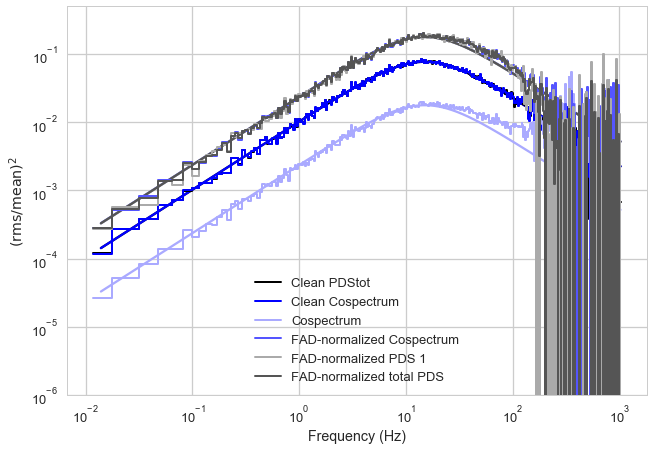

In [68]:
model = Lorentz1D(x_0=0, fwhm=30, amplitude=20)
label, fad_delta = \
    simulate_spectrum(model, tstop=2048, segment_size=128, 
                      smoothing_alg='gauss', rms=0.5, mean_ctrate=1000,
                      norm='frac')
fit_model_to_all_data(label, model)
# fig = plot_spectrum(label, rebin_factor=1., ylim=None, show=True, subtract_mean=False)

1.34504479423 4.60920463437e-05
1.33095188034 0.002342685431


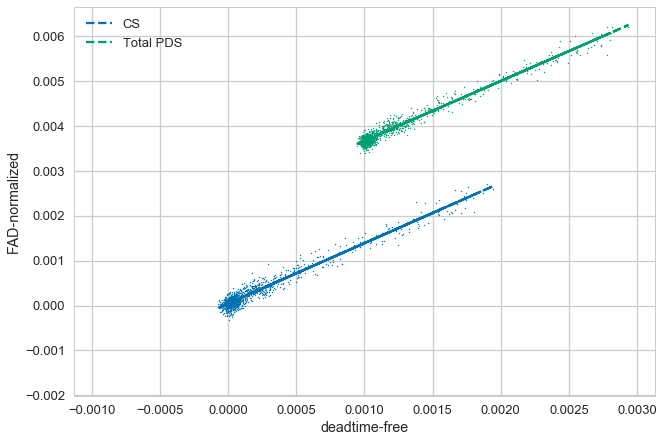

In [34]:
fig = plot_corrected_vs_clean(label, rebin_factor=1., 
                    show=True, subtract_mean=True)
# fig.gca().set_xlim([0, 400])
# fig.gca().set_ylim([-0.0005, 0.006])

1.34504479424 0
1.34504479424 0.00232530622762


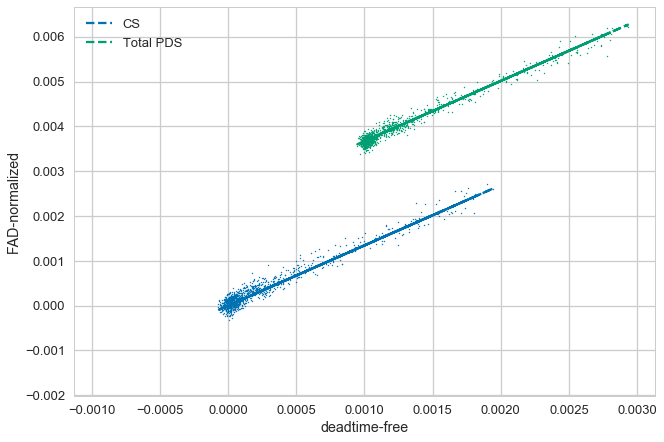

In [35]:
fig = fit_simultaneous_cs_and_pds(label, rebin_factor=1., 
                    show=True, subtract_mean=True)


In [62]:
from astropy.table import Table
import shutil

def fit_gain(file_label, rebin_factor=0.02, 
             xlim=None, ylim=None,
             show=False, subtract_mean=True):
    cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    cs_clean_reb = load_rebinned(file_label + 'cs_clean.nc', rebin_factor)
    pds_clean_reb = load_rebinned(file_label + 'pdstot_clean.nc', rebin_factor)

    slope_pds, intercept_pds, r_value, p_value, std_err = \
        linregress(pds_clean_reb.power, pdstot_norm_reb.power)
    
    slope_cs, intercept_cs, r_value, p_value, std_err = \
        linregress(cs_clean_reb.power, cs_norm_reb.power)
    
    return slope_pds, intercept_pds, slope_cs, intercept_cs


def fit_gain_simultaneous(file_label, rebin_factor=0.02, 
                          xlim=None, ylim=None,
                          show=False, subtract_mean=True, return_clean=False):
    cs_norm_reb = load_rebinned(file_label + 'cs_norm.nc', rebin_factor)
    pdstot_norm_reb = load_rebinned(file_label + 'pdstot_norm.nc', rebin_factor)
    cs_clean_reb = load_rebinned(file_label + 'cs_clean.nc', rebin_factor)
    pds_clean_reb = load_rebinned(file_label + 'pdstot_clean.nc', rebin_factor)

    par, pcov = curve_fit(line, cs_clean_reb.power, cs_norm_reb.power)
    slope, intercept = par[0], 0
    median = np.median(pds_clean_reb.power)
    par, pcov = curve_fit(offset, pds_clean_reb.power, 
                          pdstot_norm_reb.power - slope*(pds_clean_reb.power - median))
    intercept = par[0]
    
    # This is actually not an intercept, this is the white noise level of the distribution!
    # See how it is calculated 
    if not return_clean:
        return slope, intercept
    else:
        return slope, intercept, median
    

def map_fad_gain(model, N, table_file=None, 
                 smoothing_alg='gauss', fit_ref='pds'):
    try:
        table = Table.read(table_file)
    except:
        table = Table(names=('fad_delta,channel_ratio,incident_rate,length,'
                             'segment size,fit_ref,flux_correction,smoothing,'
                             'smoothing length,rms,pds_m,pds_q,cs_m,cs_q,slope,intercept').split(','),
                      dtype=[float, float, float, float, float, 'S6', bool, 'S6', 
                             float,float, float, float, float, float, float, float])

    for i in range(N):
        channel_ratio = np.random.uniform(0.8, 1.2)
        mean_ctrate = np.random.uniform(1, 1000)
        length = np.random.choice(2**np.arange(8, 11))
        segment_size = np.random.choice(2**np.arange(6, 8))
        if segment_size >= length:
            continue
        rms = np.random.uniform(0.05, 0.5)
        smoothing_length = np.random.randint(5, 7) * segment_size.astype(np.int64)

        label, fad_delta = \
            simulate_spectrum(model, tstop=length, 
                              segment_size=segment_size, 
                              channel_ratio=channel_ratio, rms=rms,
                              smoothing_alg=smoothing_alg, 
                              smoothing_length=smoothing_length,
                              mean_ctrate=mean_ctrate)
    
        slope_pds, intercept_pds, slope_cs, intercept_cs = \
            fit_gain(label, rebin_factor=1.)
        slope, intercept = \
            fit_gain_simultaneous(label, rebin_factor=1.)
    
        table.add_row([fad_delta, channel_ratio, mean_ctrate, length, 
                       segment_size, fit_ref, False, smoothing_alg, 
                       smoothing_length, rms,
                       slope_pds, intercept_pds, slope_cs, intercept_cs, slope, intercept])

        for file in glob.glob(label + '*.nc'):
            os.unlink(file)
            pdsdir = file.replace('.nc', '')
            if os.path.exists(pdsdir) and os.path.isdir(pdsdir):
                shutil.rmtree(pdsdir)

        if table_file is not None:
            table.write(table_file,overwrite=True)
    return table

model_highfreq = Lorentz1D(x_0=200, fwhm=30, amplitude=20) + Lorentz1D(x_0=30, fwhm=30, amplitude=20)


In [37]:
# table = map_fad_gain(model_highfreq, 1, table_file='results_fad_gain.csv')
# table

In [38]:
# count = 0
# errcount = 0

# while(1):
#     try:
#         results = map_fad_gain(model_highfreq, 1, table_file='results_fad_gain.csv')
#         count += 1
#         print('Realization n. {} completed'.format(count), end='\r')
#     except KeyboardInterrupt:
#         print('Ok. (after {} realizations)'.format(count))
#         break
#     except Exception as e:
#         with open('err.log', 'a') as errlog:
#             print(str(e), file=errlog)
#         if errcount > 10:
#             break
#         errcount += 1

In [39]:
# results = read_csv('results_fad_gain.csv')
# results

0.000460411569229


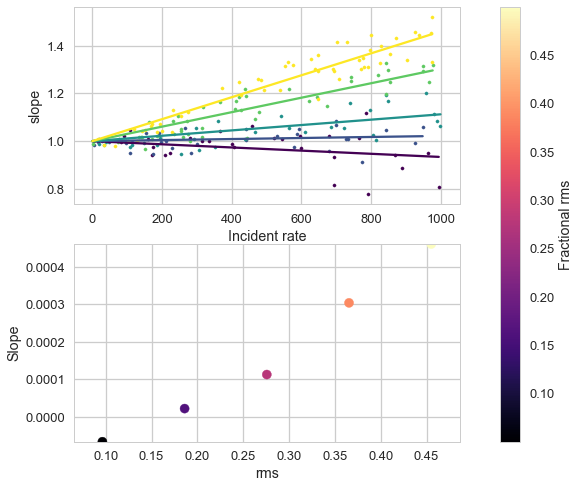

In [40]:
from scipy.optimize import curve_fit


def fit_pds_slope_vs_rms(file, toler_d_clean=0.01, 
                         filters={'channel_ratio': [0.8, 1.2]}):
    from scipy.optimize import curve_fit
    from matplotlib.pyplot import cm
    from matplotlib.gridspec import GridSpec
    import matplotlib as mpl

    results = read_csv(file)
    good_clean = np.isclose(results['pds_m'], results['cs_m'], rtol=0.05)&\
        (results['slope'] == results['slope'])
    for key, val in filters.items():
        good_clean = good_clean & (results[key] > val[0])&(results[key] < val[1])
 
    fig = plt.figure(figsize=(8, 8))

    plt.title('rms error vs rate ratio correlation')
    gs = GridSpec(2, 2, width_ratios=[9.5, 0.5])
    ax0 = plt.subplot(gs[0, 0])
    ax1 = plt.subplot(gs[1, 0])
    ax2 = plt.subplot(gs[:, 1])
    nsub = 5
    frac_rmss = np.linspace(np.min(results['rms'][good_clean]),
                            np.max(results['rms']), nsub + 1)
    colors=iter(cm.viridis(np.linspace(0,1,nsub)))
    ms = []
    qs = []
    for frac_rms_min, frac_rms_max in zip(frac_rmss[:-1], frac_rmss[1:]):

        good_rms = (results['rms'] >= frac_rms_min)&(results['rms'] < frac_rms_max)
        good = good_rms & good_clean

        x = results['incident_rate'][good]
        y = results['slope'][good]
        color = next(colors)
        ax0.scatter(x, y, c=color, s=10)
        try:
            par, pcov = curve_fit(line_to_zero, x, y - 1)
            x = np.linspace(0, max(x), 50)
            ax0.plot(x, x * par[0] + 1, color=color)
            ms.append(par[0])
            qs.append(1)
        except Exception as e:
            print(e)
            ms.append(np.nan)
            qs.append(np.nan)
         
    ms = np.array(ms)
    qs = np.array(qs)
    
    ratio = results['pds_q'][good_clean]/results['pds_m'][good_clean]
#     ax0.set_ylim([np.min(ratio), np.max(ratio)])
    ax0.set_xlabel('Incident rate')
    ax0.set_ylabel('slope')
#     ax0.set_xlim([0, np.max(results['incident_rate'])])

    colors=cm.magma(np.linspace(0,1,nsub))

    frac_rmss = np.mean(list(zip(frac_rmss[:-1], frac_rmss[1:])), axis=1)
#     ax1.scatter(results['incident_rate'][good_clean], 
#                 ratio, 
#                 c=results['rms'][good_clean], s=10, cmap='viridis')
    good = ms == ms
    ax1.scatter(frac_rmss[good], ms[good], c=colors[good], cmap='viridis')
    ax1.set_ylim([np.min(ms), np.max(ms)])
#     slope, intercept, r_value, p_value, std_err = \
#         linregress(frac_rmss[good], coeffs[good])
#     par, pcov = curve_fit(square, frac_rmss[good], ms[good] - 1, p0=[0.0])

#     x = np.linspace(0, np.max(results['rms']), 50)
#     ax1.plot(x, x * slope + intercept)
#     ax1.plot(x, x**2 * par[0] + 1)
    ax1.set_xlabel('rms')
    ax1.set_ylabel('Slope')
#     ax1.set_xlim([0, np.max(results['rms'])])
#     ax1.set_ylim([np.min([np.min(coeffs), 1]), np.max(coeffs)])
#     ax1.set_ylim([np.min([np.min(coeffs), intercept]), np.max(coeffs)])
#     print(slope,intercept)
    print(par[0])
    cmap = mpl.cm.magma
    norm = mpl.colors.Normalize(vmin=np.min(results['rms']),
                                vmax=np.max(results['rms']))

    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm)
    cb.set_label('Fractional rms')


fit_pds_slope_vs_rms('results_fad_gain.csv', toler_d_clean=0.01, 
                     filters={'channel_ratio': [0.7, 1.3]})

## And now, some statistics.

In [63]:
from astropy.table import Table
import shutil

def map_fad_gain_with_channel_ratio(N, table_file=None, 
                                    smoothing_alg='gauss', fit_ref='pds'):
    try:
        table = Table.read(table_file)
    except:
        table = Table(names=('frequency,input_rms,channel_ratio,incident_rate,length,'
                             'segment size,fit_ref,flux_correction,smoothing,'
                             'smoothing length,fad_delta,Frac_rms,delta clean,CS,PDS 1,PDStot,'
                             'slope,median,clean_median').split(','),
                      dtype=[float,float, float, float, float, float, 'S6', bool, 'S6', 
                             float, float, float, float, float, float, float, float, float, float])
    model = Lorentz1D(x_0=200, fwhm=20, amplitude=20)
    for i in range(N):
        channel_ratio = np.random.uniform(0.5, 2)
        mean_ctrate = np.random.uniform(10, 1000)
        length = np.random.choice(2**np.arange(9, 11))
        segment_size = np.random.choice(2**np.arange(6, 9))
        if segment_size >= length:
            continue
        rms = np.random.uniform(0.05, 0.5)
        smoothing_length = np.random.randint(5, 7) * segment_size.astype(np.int64)
        frequency = np.random.uniform(0, 300) 
        model.x_0 = frequency

        label, fad_delta = \
            simulate_spectrum(model, tstop=length, segment_size=segment_size, 
                              channel_ratio=channel_ratio, rms=rms,
                              smoothing_alg=smoothing_alg, 
                              smoothing_length=smoothing_length,
                              mean_ctrate=mean_ctrate)
        slope, intercept, intercept_clean = \
            fit_gain_simultaneous(label, rebin_factor=1., return_clean=True)

        deltas = fit_model_to_all_data(label, model, plot=False, 
                                       print_results=False, fmin=0, fmax=2048,
                                       fit_ref=fit_ref)
      
        table.add_row([frequency, rms, channel_ratio, mean_ctrate, length, 
                       segment_size, fit_ref, False, smoothing_alg, 
                       smoothing_length, fad_delta,
                       deltas['Frac_rms'], deltas['delta clean'], 
                       deltas['CS'], deltas['PDS'], deltas['PDStot'], 
                       slope, intercept, intercept_clean])
        
        for file in glob.glob(label + '*.nc'):
            os.unlink(file)
            pdsdir = file.replace('.nc', '')
            if os.path.exists(pdsdir) and os.path.isdir(pdsdir):
                shutil.rmtree(pdsdir)

    if table_file is not None:
        table.write(table_file,overwrite=True)
    return table

In [64]:
# benchmark
# %prun -D profile_spline.prof map_fad_gain_with_channel_ratio(model, 1, table_file='results.csv', smoothing_alg='spline')


In [65]:
%prun -D profile_gauss.prof map_fad_gain_with_channel_ratio(1, table_file='results_allfreq.csv', smoothing_alg='gauss')

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


 
*** Profile stats marshalled to file 'profile_gauss.prof'. 


In [60]:
# !snakeviz profile_gauss.prof

In [ ]:
count = 0
errcount = 0

while(1):
    try:
        results = map_fad_gain_with_channel_ratio(1, table_file='results_allfreq.csv',
                                                  smoothing_alg='gauss', fit_ref='cs')
        count += 1
        print('Realization n. {} completed'.format(count), end='\r')
    except KeyboardInterrupt:
        print('Ok. (after {} realizations)'.format(count))
        break
    except Exception as e:
        with open('err.log', 'a') as errlog:
            print(str(e), file=errlog)
        if errcount > 10:
            break
        errcount += 1


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:211: Runtime

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:161: Runtime

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: Runtime

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:211: Runtime

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: Runtime

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: Runtime

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: Runtime

/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:211: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in double_scalars
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)
/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


/home/mbachett/anaconda/envs/py36/lib/python3.6/site-packages/stingray-0.1.dev1273-py3.6.egg/stingray/utils.py:73: UserWarning: SIMON says: Stingray only uses poisson err_dist at the moment, We are setting your errors to zero. Sorry for the inconvenience.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


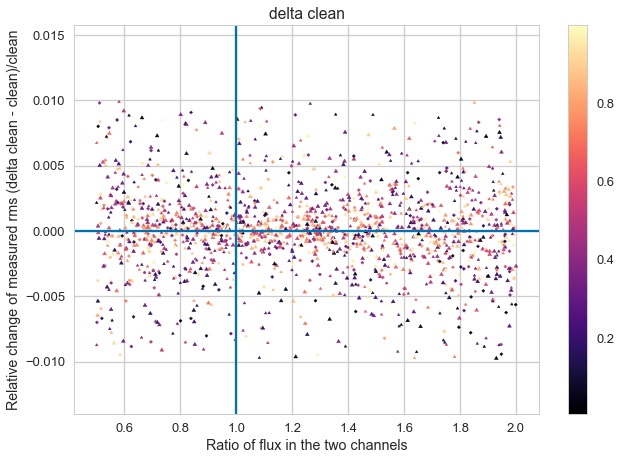

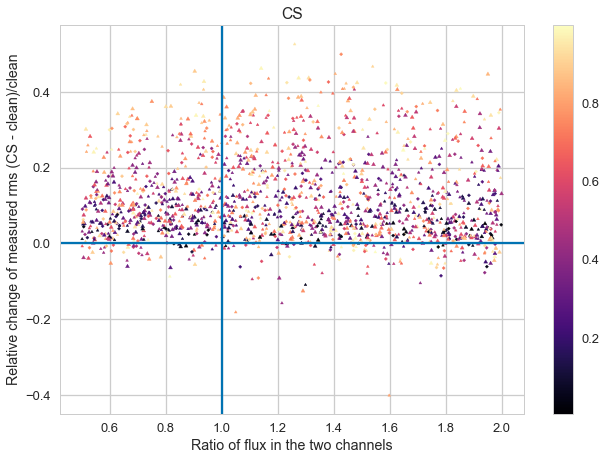

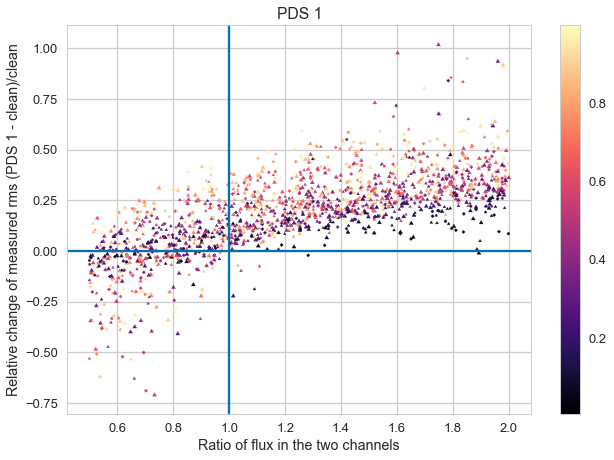

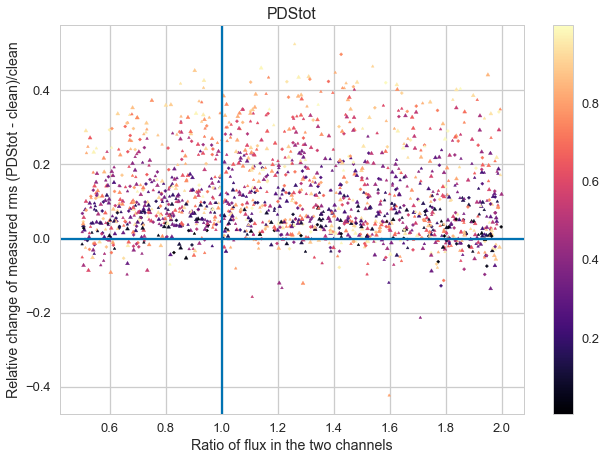

In [45]:
plot_all('results_rn.csv')

ValueError: max must be larger than min in range parameter.

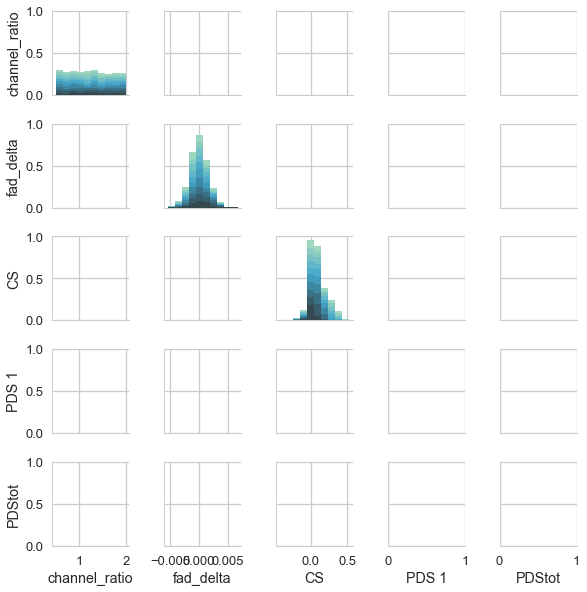

In [56]:
pairplot('results_rn.csv')

In [47]:
stats('results_rn.csv')

CS:
Mean _relative_ shift ((CS - clean)/clean) = (11.8 +- 11.3)%
PDStot:
Mean _relative_ shift ((PDStot - clean)/clean) = (11.1 +- 11.5)%
PDS 1:
Mean _relative_ shift ((PDS 1 - clean)/clean) = (18.9 +- 20.0)%


0.00331416683951


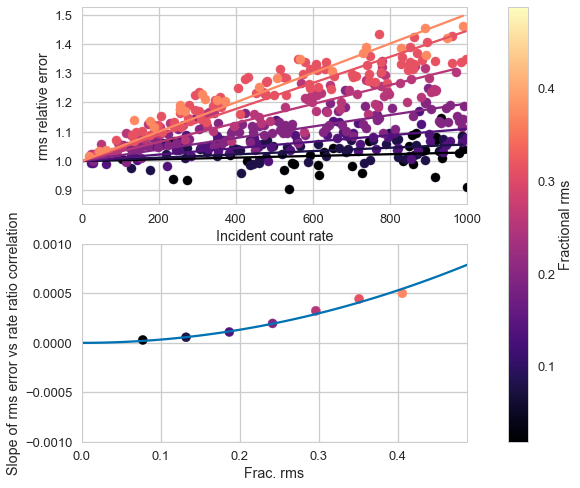

In [48]:
fit_incident_vs_delta('results_rn.csv', 
                      filters={'channel_ratio': [0.8, 1.2]})

0.00331416683951


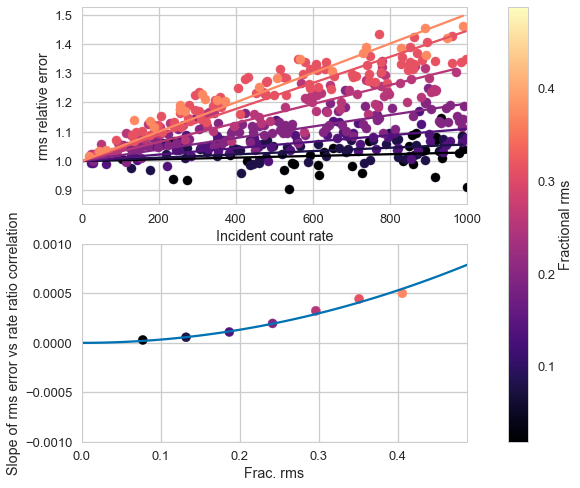

In [50]:
fit_incident_vs_delta('results_rn.csv', 
                      filters={'channel_ratio': [0.8, 1.2]})

0.00331416683951


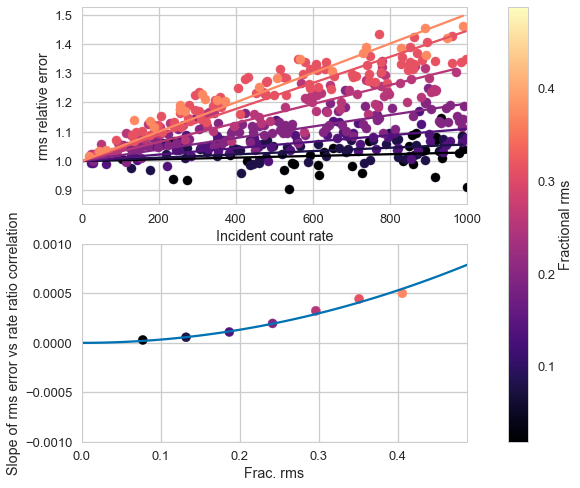

In [55]:
fit_incident_vs_delta('results_rn.csv', 
                      filters={'channel_ratio': [0.8, 1.2],
                               'length': [128, 1024]})

0.00370146096986


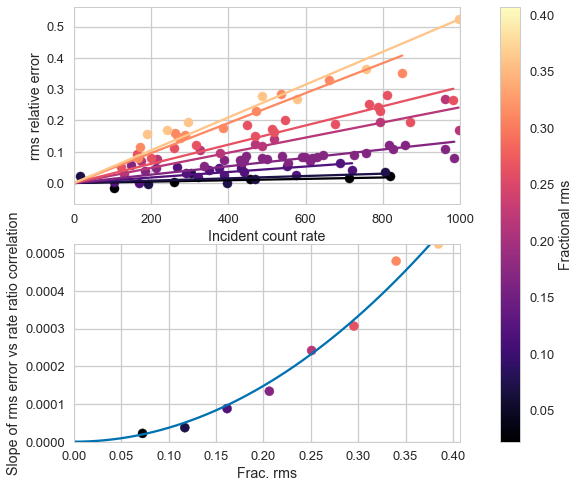

In [57]:
fit_incident_vs_delta('results_rn.csv', 
                      filters={'channel_ratio': [0.8, 1.2],
                               'segment size': [257, 513]})

0.00350949035221


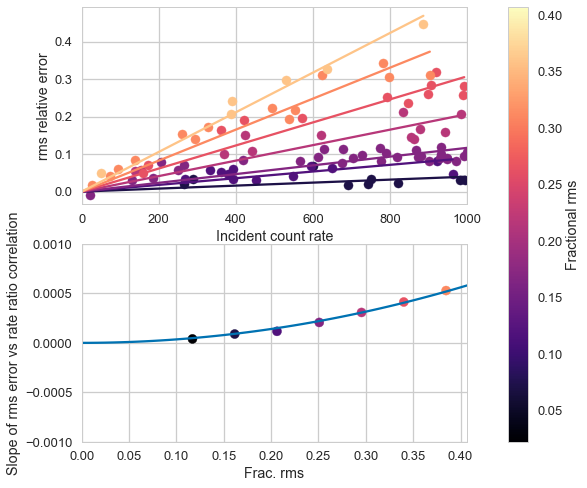

In [58]:
fit_incident_vs_delta('results_rn.csv', 
                      filters={'channel_ratio': [0.8, 1.2],
                               'segment size': [255, 257]})

In [53]:
results = read_csv('results_rn.csv')
results

,fad_delta,channel_ratio,incident_rate,length,segment size,fit_ref,flux_correction,smoothing,smoothing length,delta clean,CS,PDS 1,PDStot,Frac_rms
0,-0.001482,1.516806,860.896865,2048.0,512.0,pds,False,gauss,3072.0,-0.001501,0.063343,0.242452,0.062917,0.200000
1,-0.000583,1.100280,756.574918,2048.0,128.0,cs,False,gauss,768.0,-0.011014,0.071017,0.120271,0.071165,0.200000
2,0.001183,1.895619,606.667778,2048.0,64.0,cs,False,gauss,320.0,-0.003393,-0.020070,0.224269,-0.028322,0.200000
3,-0.001504,1.829629,671.978132,1024.0,512.0,cs,False,gauss,3072.0,0.002569,0.044538,0.317925,0.048979,0.200000
4,0.000749,1.650173,265.705113,1024.0,256.0,cs,False,gauss,1280.0,-0.005446,0.037437,0.234574,0.037690,0.200000
5,-0.000723,1.134919,616.684370,2048.0,512.0,cs,False,gauss,3072.0,-0.000847,0.079162,0.139316,0.079803,0.200000
6,0.000368,1.746745,998.524862,1024.0,256.0,cs,False,gauss,1280.0,0.003634,0.023792,0.284304,0.027414,0.200000
7,-0.001190,1.579660,482.237165,2048.0,512.0,cs,False,gauss,2560.0,-0.002244,0.060675,0.242184,0.058673,0.200000
8,0.000678,0.686440,108.295760,2048.0,64.0,cs,False,gauss,320.0,0.008281,-0.014881,-0.130014,-0.021520,0.200000
9,0.000474,1.650813,778.064998,1024.0,128.0,cs,False,gauss,768.0,-0.005805,0.026137,0.236033,0.022869,0.200000
